# CubeSatNet Improvements for VERTECS – Team 5

## Notebook 4: Classification using CNN

In this notebook, we will use a CNN model to classify the images, following the approach used in the following [paper](https://ui.adsabs.harvard.edu/abs/2023SPIE12729E..0KC/abstract).

---

In [ ]:
# Standard Library Imports
import os
import sys
import warnings
import pickle

# Third-Party Imports
import numpy as np               
import pandas as pd              
import matplotlib.pyplot as plt  
import seaborn as sns            

# TensorFlow and Keras Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    SeparableConv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Dense,
    BatchNormalization,
    Dropout
)

# For one-hot encoding of labels
from tensorflow.keras.utils import to_categorical

# TensorFlow Model Optimization (for pruning)
import tensorflow_model_optimization as tfmot

# Optional compatibility import for pruning 
from tensorflow_model_optimization.python.core.keras.compat import keras

# Environment Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")


In [ ]:
# Defining a function to save the model as well as measure its size

def measure_model_size(model, filename):
    # Save the model with pickle
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    
    # Get the file size in bytes
    size_bytes = os.path.getsize(filename)
    size_kb = size_bytes / 1024.0
    size_mb = size_kb / 1024.0
    
    # Print the file size in different units
    print(f"Model saved to {filename}.\n")
    print(f"Size: {size_bytes} bytes ({size_kb:.2f} KB, {size_mb:.2f} MB).")
    
    return size_bytes

### Reading the data

First, we’ll load the saved image and label data from the NumPy files.

In [1]:
# Load the images and labels back from the saved NumPy files
train_images = np.load('data/train_images.npy')  # Load image training data
train_labels = np.load('data/train_labels.npy')  # Load label training data

print("Data loaded successfully from NumPy files.")

Data loaded successfully from NumPy files.


---

### Train CubeCatNet CNN model

We will define and train a Convolutional Neural Network (CNN) model that was defined in [link](https://ui.adsabs.harvard.edu/abs/2023SPIE12729E..0KC/abstract).

In [2]:
# One-hot encode the labels (assuming you have 5 classes)
train_labels = to_categorical(train_labels, num_classes=5)

print("Train labels shape: ", train_labels.shape)

2025-03-06 15:01:44.678412: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 15:01:44.684978: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 15:01:44.697200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741266104.717723  114721 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741266104.723841  114721 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 15:01:44.745907: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Train labels shape:  (9711, 5)


In [3]:
from tensorflow_model_optimization.python.core.keras.compat import keras

# Define the sampled model using depthwise separable convolutions: MAIN best archietcure so far
model_for_pruning = keras.Sequential([
    # First stage: Depthwise separable conv with stride and then MaxPooling
    keras.layers.SeparableConv2D(16, (3, 3), strides=(2, 2), padding='same',
                                 activation='relu', input_shape=(512, 512, 3)),
    keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
    
    # Second stage
    keras.layers.SeparableConv2D(32, (3, 3), strides=(2, 2), padding='same',
                                 activation='relu'),
    keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
    
    # Third stage
    keras.layers.SeparableConv2D(64, (3, 3), strides=(2, 2), padding='same',
                                 activation='relu'),
    keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
    
    # Fourth stage
    keras.layers.SeparableConv2D(128, (3, 3), strides=(2, 2), padding='same',
                                 activation='relu'),
    keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
    
    # Global pooling and classification head
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(5, activation='softmax')
])

print("Sampled model defined successfully.")
model_for_pruning.summary()

Sampled model defined successfully.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separabl  (None, 256, 256, 16)      91        
 eConv2D)                                                        
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 separable_conv2d_1 (Separa  (None, 64, 64, 32)        688       
 bleConv2D)                                                      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 separable_conv2d_2 

2025-03-06 15:01:52.643596: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
# Compile the model with appropriate loss function, optimizer, and metrics
# # Compile the initial model for pruning 

model_for_pruning.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

print("Model compiled successfully.")

Model compiled successfully.


In [6]:
print("train_images shape:", train_images.shape)  # Should be (num_samples, height, width, channels)
print("train_labels shape:", train_labels.shape)  # Should be (num_samples, 5)

train_images shape: (9711, 512, 512, 3)
train_labels shape: (9711, 5)


In [7]:
# print("Before reshape:", train_labels.shape)  # (9711, 5, 5)
# train_labels = train_labels.reshape(-1, 5)
# print("After reshape:", train_labels.shape) 

In [8]:
def prune_model(model, initial_sparsity=0.0, final_sparsity=0.5, begin_step=0, end_step=1000):
    """
    Apply pruning to the model with the specified parameters
    """
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=initial_sparsity,
            final_sparsity=final_sparsity,
            begin_step=begin_step,
            end_step=end_step
        )
    }
    
    # Wrap the model for pruning
    pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)
    
    # Compile the pruned model
    pruned_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return pruned_model

In [9]:
# 3. Apply pruning to the model using the provided function
import tensorflow_model_optimization as tfmot

pruned_model = prune_model(
    model_for_pruning, 
    initial_sparsity=0.0, 
    final_sparsity=0.5, 
    begin_step=0, 
    end_step=1000
)

print("Pruned model defined and compiled successfully.")

Pruned model defined and compiled successfully.


In [10]:
# Set up pruning callbacks (updates pruning step and logs summaries)
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir='./logs')
]

In [11]:
# Train the model on the training data
history = pruned_model.fit(
    train_images, train_labels,
    epochs=10,  # Number of epochs
    batch_size=64,  # Batch size
    callbacks=callbacks # only used when pruning the model
)

print("\nModel training complete.")
print("Pruned model training complete.")

Epoch 1/10
152/152 [==============================] - 64s 401ms/step - loss: 0.8532 - accuracy: 0.6599
Epoch 2/10
152/152 [==============================] - 62s 406ms/step - loss: 0.3220 - accuracy: 0.9010
Epoch 3/10
152/152 [==============================] - 60s 396ms/step - loss: 0.1327 - accuracy: 0.9665
Epoch 4/10
152/152 [==============================] - 61s 405ms/step - loss: 0.0576 - accuracy: 0.9863
Epoch 5/10
152/152 [==============================] - 63s 412ms/step - loss: 0.0334 - accuracy: 0.9912
Epoch 6/10
152/152 [==============================] - 62s 405ms/step - loss: 0.0208 - accuracy: 0.9939
Epoch 7/10
152/152 [==============================] - 61s 399ms/step - loss: 0.0141 - accuracy: 0.9960
Epoch 8/10
152/152 [==============================] - 62s 405ms/step - loss: 0.0134 - accuracy: 0.9955
Epoch 9/10
152/152 [==============================] - 63s 416ms/step - loss: 0.0100 - accuracy: 0.9970
Epoch 10/10
152/152 [==============================] - 69s 455ms/step - l

The model only takes about 11 minutes and 12 seconds to train ie for the depth separable conv2D

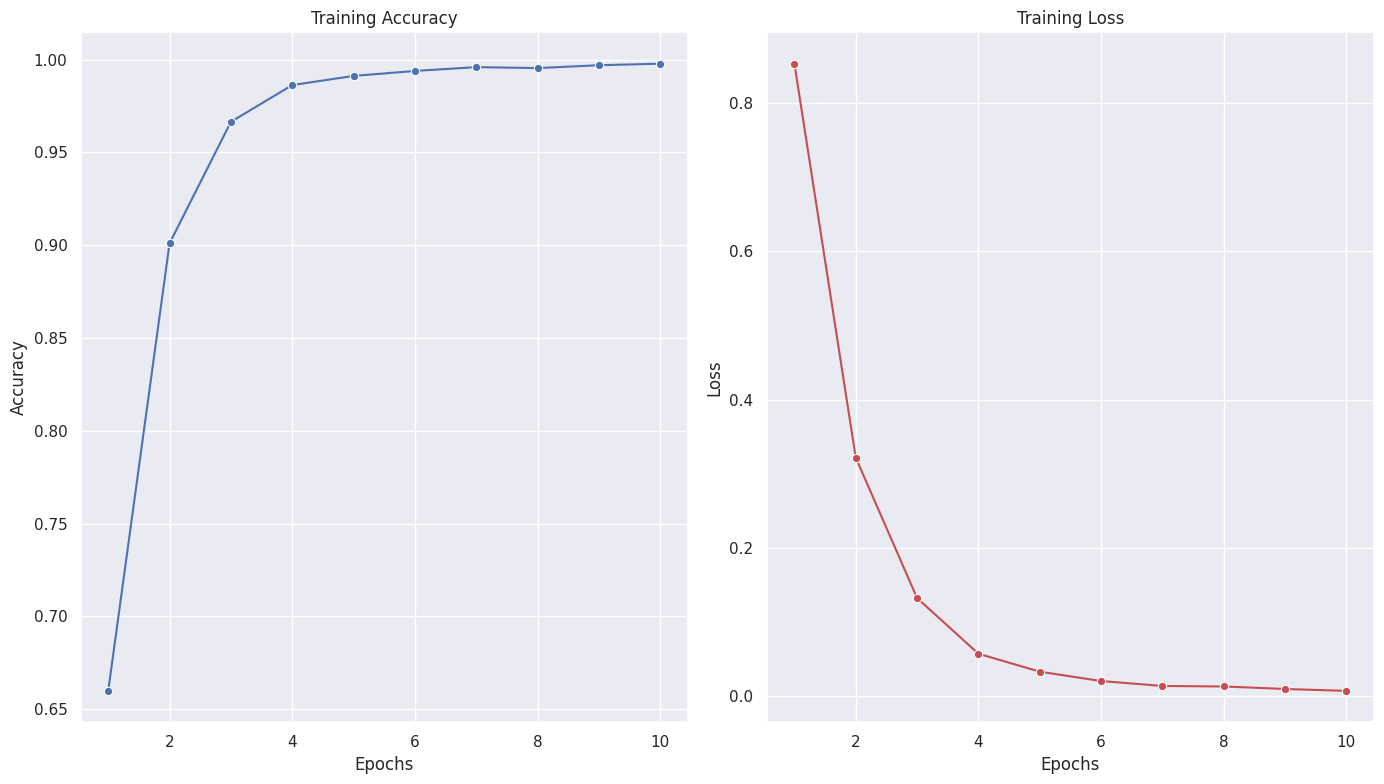

In [12]:
# Assuming 'history' is the History object returned by model.fit()
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)

# Create a DataFrame for easier plotting with seaborn
data = pd.DataFrame({
    'Epoch': epochs,
    'Accuracy': acc,
    'Loss': loss
})

# Set a Seaborn theme for improved aesthetics
sns.set_theme(style="darkgrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Plot training accuracy using seaborn lineplot
sns.lineplot(data=data, x='Epoch', y='Accuracy', marker="o", ax=axes[0])
axes[0].set_title('Training Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')

# Plot training loss using seaborn lineplot
sns.lineplot(data=data, x='Epoch', y='Loss', marker="o", color='r', ax=axes[1])
axes[1].set_title('Training Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

##### **Saving the CNN model**

In [15]:
# Strip the pruning wrappers to get the final model

final_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

# Save the final pruned model
final_model.save('models/cnn_model_full_SepConv2D_pruned_model_V2.h5')

print("Final pruned model saved as .h5.")

Final pruned model saved as .h5.


In [16]:
# Example usage:
model_size = measure_model_size(final_model, 'models/cnn_model_full_separableConv2D_pruned_V1.pkl')

print("Final pruned model saved as pkl.")

Model saved to models/cnn_model_full_separableConv2D_pruned_V1.pkl.

Size: 85278 bytes (83.28 KB, 0.08 MB).
Final pruned model saved as pkl.


In [17]:
# import pickle

# with open('cnn_model_v1.pkl', 'wb') as file:
#     pickle.dump(model, file)

In [17]:
import gc

# Since we will no longer need the original training data (train_images), we can remove it from memory
del train_images, train_labels

# Force garbage collection to free up memory
gc.collect()

print("train_images, and train_labels removed from memory.")

train_images, and train_labels removed from memory.


---

### Deep learning: Validation set results

In [18]:
val_images = np.load('data/val_images.npy')  # Load image val data
val_labels = np.load('data/val_labels.npy')  # Load label val data

val_labels = to_categorical(val_labels, num_classes=5)

print("Train validation labels shape: ", val_labels.shape)

Train validation labels shape:  (3237, 5)


In [19]:
with open('models/cnn_model_full_separableConv2D_pruned_V1.pkl', 'rb') as file:
    cnn_loaded_model = pickle.load(file)
    
val_predictions = cnn_loaded_model.predict(val_images)

102/102 [==============================] - 8s 81ms/step


In [20]:
from sklearn.metrics import classification_report, confusion_matrix

# Convert from one-hot or probability distributions to single integer class indices
val_predictions = np.argmax(val_predictions, axis=1) 
val_labels = np.argmax(val_labels, axis=1) 


# Detailed classification report
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       727
           1       1.00      1.00      1.00       222
           2       1.00      1.00      1.00       421
           3       1.00      1.00      1.00       721
           4       1.00      1.00      1.00      1146

    accuracy                           1.00      3237
   macro avg       1.00      1.00      1.00      3237
weighted avg       1.00      1.00      1.00      3237



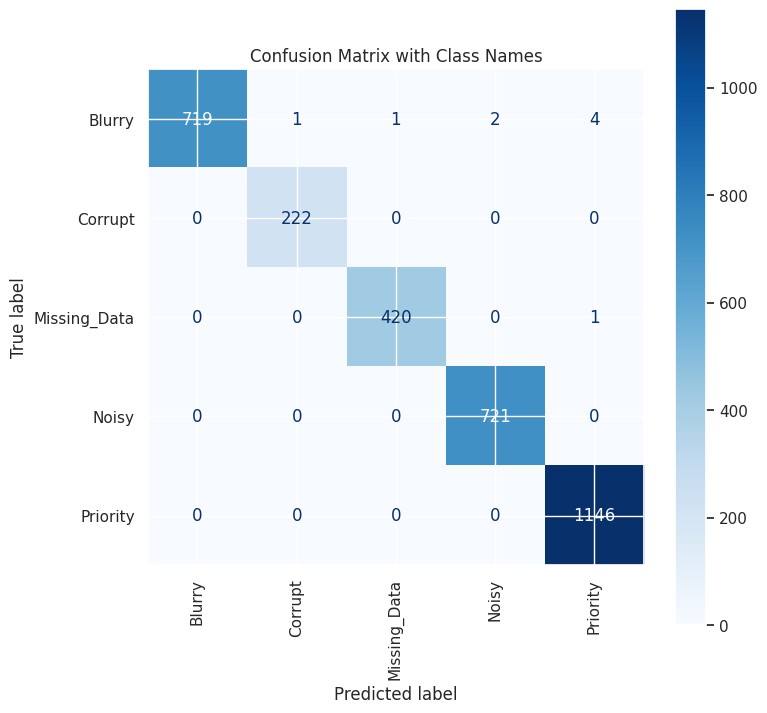

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define class names
class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]

# Compute the confusion matrix
cm = confusion_matrix(val_labels, val_predictions)

# Plot the confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Customize and display the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Set the figure size
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')  # Use a blue colormap
plt.title("Confusion Matrix with Class Names")
plt.show()

---

##### **⚠️ Freeing up Space**

In [31]:
import gc

# Since we will no longer need the original training data (train_images), we can remove it from memory
del val_predictions, val_labels, val_images

# Force garbage collection to free up memory
gc.collect()

%reset -f
print("Data removed from memory.")

Data removed from memory.


---

### Saving the Final Quantized model

In [22]:
def quantize_model(model, output_path):
    """
    Apply post-training quantization to the pruned model and save as TFLite
    """
    # Convert the model to a TFLite model with post-training quantization
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    quantized_tflite_model = converter.convert()
    
    # Save the quantized TFLite model
    with open(output_path, 'wb') as f:
        f.write(quantized_tflite_model)
    
    print(f"Quantized TFLite model saved at: {output_path}")
    return quantized_tflite_model

In [24]:
# Apply post-training quantization to the final model and save as a TFLite model

quantized_model = quantize_model(
    final_model, 
    output_path='models/cnn_model_full_SepConv2D_quantized_model_V1.tflite'
)

INFO:tensorflow:Assets written to: /tmp/tmp5rsylb0c/assets


INFO:tensorflow:Assets written to: /tmp/tmp5rsylb0c/assets


Quantized TFLite model saved at: models/cnn_model_full_SepConv2D_quantized_model_V1.tflite


W0000 00:00:1741267003.555371  114721 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1741267003.555411  114721 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-06 15:16:43.555619: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp5rsylb0c
2025-03-06 15:16:43.557652: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-06 15:16:43.557673: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp5rsylb0c
2025-03-06 15:16:43.566753: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-06 15:16:43.594318: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp5rsylb0c
2025-03-06 15:16:43.605893: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 50275 microseconds.


In [25]:
def get_model_size(file_path):
    
    size_bytes = os.path.getsize(file_path)
    size_kb = size_bytes / 1024         # Convert bytes to kilobytes
    size_mb = size_bytes / (1024 * 1024)  # Convert bytes to megabytes
    
    return size_kb, size_mb

In [26]:
# Example usage:
model_path = 'models/cnn_model_full_SepConv2D_quantized_model_V1.tflite'

kb, mb = get_model_size(model_path)

print("Model size: %.2f KB (%.2f MB)" % (kb, mb))

Model size: 28.28 KB (0.03 MB)
